<a href="https://colab.research.google.com/github/bhanup6663/COMP691_DL/blob/main/Challange2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MobileNet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset,DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

100%|██████████| 170498071/170498071 [00:13<00:00, 12580727.43it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
selected_classes = np.random.choice(range(10), 2, replace=False)
print(selected_classes)

[2 9]


In [6]:
model = models.mobilenet_v2(pretrained=True)

num_classes = 10
dropout_rate = 0.5

model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 134MB/s]


In [7]:
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

In [8]:
best_val_accuracy = 0
best_model_weights = None

In [9]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [10]:
def validate(model, device, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(val_loader):
            data, targets = data.to(device), targets.to(device)
            output = model(data)
            loss = criterion(output, targets)

            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [11]:
class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

In [12]:
for fold, (train_ids, val_ids) in enumerate(kfold.split(trainset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_indices = [i for i, (_, label) in enumerate(trainset) if label in selected_classes]

    N = 25
    class_counts = {label: 0 for label in selected_classes}
    filtered_train_indices = []

    for i in train_indices:
        _, label = trainset[i]
        if class_counts[label] < N:
            filtered_train_indices.append(i)
            class_counts[label] += 1


    np.random.seed(42)
    np.random.shuffle(filtered_train_indices)
    split = int(0.8 * len(filtered_train_indices))
    train_idx, val_idx = filtered_train_indices[:split], filtered_train_indices[split:]

    train_subset = Subset(trainset, train_idx)
    transformed_train_subset = TransformSubset(train_subset, transform=train_transform)

    val_subset = Subset(trainset, val_idx)
    transformed_val_subset = TransformSubset(val_subset, transform=test_transform)

    train_loader = DataLoader(transformed_train_subset, batch_size=5, shuffle=True)
    val_loader = DataLoader(transformed_val_subset, batch_size=5, shuffle=False)


    # Init the neural network
    model = model.to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25


    # Run the training loop for defined number of epochs
    num_epochs = 50
    for epoch in range(num_epochs):
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Perform training and validation
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
        val_loss, val_accuracy = validate(model, device, val_loader, criterion)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Save the model if it has the best val accuracy so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()  # Save the best model weights
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break  # Stop training if no improvement

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    print('--------------------------------')

# Save the best model weights
torch.save(best_model_weights, 'c2_mobilenet_best_model.pth')
print(f'Best validation accuracy of {best_val_accuracy:.2f}% achieved, model saved as c2_mobilenet_best_model.pth')

FOLD 0
--------------------------------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Starting epoch 1
Train Loss: 2.7680, Train Acc: 5.00%, Val Loss: 2.3530, Val Acc: 0.00%
Starting epoch 2
Train Loss: 2.4923, Train Acc: 15.00%, Val Loss: 2.2751, Val Acc: 10.00%
Starting epoch 3
Train Loss: 2.4216, Train Acc: 20.00%, Val Loss: 2.1477, Val Acc: 20.00%
Starting epoch 4
Train Loss: 2.2317, Train Acc: 20.00%, Val Loss: 2.0767, Val Acc: 20.00%
Starting epoch 5
Train Loss: 2.1664, Train Acc: 20.00%, Val Loss: 2.0892, Val Acc: 20.00%
Starting epoch 6
Train Loss: 2.3874, Train Acc: 20.00%, Val Loss: 2.0064, Val Acc: 30.00%
Starting epoch 7
Train Loss: 2.1416, Train Acc: 20.00%, Val Loss: 2.0487, Val Acc: 30.00%
Starting epoch 8
Train Loss: 2.0813, Train Acc: 25.00%, Val Loss: 1.9818, Val Acc: 20.00%
Starting epoch 9
Train Loss: 1.8639, Train Acc: 32.50%, Val Loss: 1.7933, Val Acc: 60.00%
Starting epoch 10
Train Loss: 1.8663, Train Acc: 35.00%, Val Loss: 1.8812, Val Acc: 40.00%
Starting epoch 11
Train Loss: 1.6177, Train Acc: 50.00%, Val Loss: 1.8508, Val Acc: 40.00%
Starting e

In [13]:
model = model.to(device)
model.load_state_dict(torch.load('c2_mobilenet_best_model.pth'))

<All keys matched successfully>

In [14]:
test_indices = [i for i, (_, label) in enumerate(testset) if label in selected_classes]
N = 1000
class_counts = {label: 0 for label in selected_classes}
filtered_train_indices = []

for i in test_indices:
    _, label = testset[i]
    if class_counts[label] < N:
        filtered_train_indices.append(i)
        class_counts[label] += 1

test_subset = Subset(testset, filtered_train_indices)
test_loader = DataLoader(test_subset, batch_size=50, shuffle=False)

In [15]:
# Ensure the model is in evaluation mode
model.eval()

# Assuming the test_loader and the device are already defined
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Evaluation
test_loss = 0
correct = 0
total = 0

# No gradient is needed for evaluation
with torch.no_grad():
    for data, targets in test_loader:
        # Move data and targets to the correct device
        data = data.to(device)
        targets = targets.to(device)

        # Compute the model output
        output = model(data)
        loss = criterion(output, targets)

        # Accumulate the loss and calculate accuracy
        test_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# Calculate average loss and accuracy percentage
modilenet_avg_loss = test_loss / len(test_loader)
mobilenet_accuracy = 100. * correct / total

# Print the test loss and accuracy
print(f'Test Loss: {modilenet_avg_loss:.4f}, Test Accuracy: {mobilenet_accuracy:.2f}%')


Test Loss: 0.9879, Test Accuracy: 68.05%


Resnet

In [16]:
model = models.resnet18(pretrained=True)

num_classes = 10
dropout_rate = 0.5

# Modify the fully connected layer
model.fc = nn.Sequential(
    nn.Dropout(dropout_rate),
    nn.Linear(model.fc.in_features, num_classes)
)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


In [17]:
best_val_accuracy = 0
best_model_weights = None

In [18]:
for fold, (train_ids, val_ids) in enumerate(kfold.split(trainset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_indices = [i for i, (_, label) in enumerate(trainset) if label in selected_classes]

    N = 25
    class_counts = {label: 0 for label in selected_classes}
    filtered_train_indices = []

    for i in train_indices:
        _, label = trainset[i]
        if class_counts[label] < N:
            filtered_train_indices.append(i)
            class_counts[label] += 1


    np.random.seed(42)
    np.random.shuffle(filtered_train_indices)
    split = int(0.8 * len(filtered_train_indices))
    train_idx, val_idx = filtered_train_indices[:split], filtered_train_indices[split:]

    train_subset = Subset(trainset, train_idx)
    transformed_train_subset = TransformSubset(train_subset, transform=train_transform)

    val_subset = Subset(trainset, val_idx)
    transformed_val_subset = TransformSubset(val_subset, transform=test_transform)

    train_loader = DataLoader(transformed_train_subset, batch_size=5, shuffle=True)
    val_loader = DataLoader(transformed_val_subset, batch_size=5, shuffle=False)


    # Init the neural network
    model = model.to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.005)
    criterion = nn.CrossEntropyLoss()

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25


    # Run the training loop for defined number of epochs
    num_epochs = 50
    for epoch in range(num_epochs):
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Perform training and validation
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
        val_loss, val_accuracy = validate(model, device, val_loader, criterion)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Save the model if it has the best val accuracy so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()  # Save the best model weights
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break  # Stop training if no improvement

        # Step the learning rate scheduler
        scheduler.step(val_loss)

    print('--------------------------------')

# Save the best model weights
torch.save(best_model_weights, 'c2_Resnet_best_model.pth')
print(f'Best validation accuracy of {best_val_accuracy:.2f}% achieved, model saved as c2_Resnet_best_model.pth')

FOLD 0
--------------------------------
Starting epoch 1
Train Loss: 2.6767, Train Acc: 50.00%, Val Loss: 27548.7178, Val Acc: 40.00%
Starting epoch 2
Train Loss: 3.0435, Train Acc: 45.00%, Val Loss: 1532.3817, Val Acc: 40.00%
Starting epoch 3
Train Loss: 2.1125, Train Acc: 50.00%, Val Loss: 219.8216, Val Acc: 60.00%
Starting epoch 4
Train Loss: 2.0548, Train Acc: 52.50%, Val Loss: 457.2386, Val Acc: 50.00%
Starting epoch 5
Train Loss: 1.9019, Train Acc: 55.00%, Val Loss: 120.7160, Val Acc: 50.00%
Starting epoch 6
Train Loss: 2.1822, Train Acc: 57.50%, Val Loss: 27.3671, Val Acc: 40.00%
Starting epoch 7
Train Loss: 1.4998, Train Acc: 47.50%, Val Loss: 132.2333, Val Acc: 50.00%
Starting epoch 8
Train Loss: 1.4128, Train Acc: 47.50%, Val Loss: 10.2816, Val Acc: 50.00%
Starting epoch 9
Train Loss: 1.5218, Train Acc: 47.50%, Val Loss: 2.0399, Val Acc: 50.00%
Starting epoch 10
Train Loss: 1.4289, Train Acc: 52.50%, Val Loss: 3.6114, Val Acc: 50.00%
Starting epoch 11
Train Loss: 1.1345, Trai

In [19]:
model = model.to(device)
model.load_state_dict(torch.load('c2_Resnet_best_model.pth'))

<All keys matched successfully>

In [20]:
test_indices = [i for i, (_, label) in enumerate(testset) if label in selected_classes]
N = 1000
class_counts = {label: 0 for label in selected_classes}
filtered_train_indices = []

for i in test_indices:
    _, label = testset[i]
    if class_counts[label] < N:
        filtered_train_indices.append(i)
        class_counts[label] += 1

test_subset = Subset(testset, filtered_train_indices)
test_loader = DataLoader(test_subset, batch_size=50, shuffle=False)

In [21]:
# Ensure the model is in evaluation mode
model.eval()

# Assuming the test_loader and the device are already defined
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Evaluation
test_loss = 0
correct = 0
total = 0

# No gradient is needed for evaluation
with torch.no_grad():
    for data, targets in test_loader:
        # Move data and targets to the correct device
        data = data.to(device)
        targets = targets.to(device)

        # Compute the model output
        output = model(data)
        loss = criterion(output, targets)

        # Accumulate the loss and calculate accuracy
        test_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# Calculate average loss and accuracy percentage
Resnet_avg_loss = test_loss / len(test_loader)
Resnet_accuracy = 100. * correct / total

# Print the test loss and accuracy
print(f'Test Loss: {Resnet_avg_loss:.4f}, Test Accuracy: {Resnet_accuracy:.2f}%')


Test Loss: 0.6758, Test Accuracy: 63.25%


VIT

In [22]:
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models

In [23]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

In [24]:
model = models.vit_b_16(pretrained=True)

num_classes = 10
dropout_rate = 0.5

model.heads = nn.Sequential(
    nn.Dropout(p=dropout_rate),
    nn.Linear(model.heads[0].in_features, num_classes)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 86.7MB/s]


In [25]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [26]:
def validate(model, device, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(val_loader):
            data, targets = data.to(device), targets.to(device)
            output = model(data)
            loss = criterion(output, targets)

            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    avg_loss = total_loss / len(val_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [27]:
best_val_accuracy = 0
best_model_weights = None

In [28]:
for fold, (train_ids, val_ids) in enumerate(kfold.split(trainset)):
    print(f'FOLD {fold}')
    print('--------------------------------')

    train_indices = [i for i, (_, label) in enumerate(trainset) if label in selected_classes]

    N = 25
    class_counts = {label: 0 for label in selected_classes}
    filtered_train_indices = []

    for i in train_indices:
        _, label = trainset[i]
        if class_counts[label] < N:
            filtered_train_indices.append(i)
            class_counts[label] += 1


    np.random.seed(42)
    np.random.shuffle(filtered_train_indices)
    split = int(0.8 * len(filtered_train_indices))
    train_idx, val_idx = filtered_train_indices[:split], filtered_train_indices[split:]

    train_subset = Subset(trainset, train_idx)
    transformed_train_subset = TransformSubset(train_subset, transform=train_transform)

    val_subset = Subset(trainset, val_idx)
    transformed_val_subset = TransformSubset(val_subset, transform=test_transform)

    train_loader = DataLoader(transformed_train_subset, batch_size=5, shuffle=True)
    val_loader = DataLoader(transformed_val_subset, batch_size=5, shuffle=False)


    # Init the neural network
    model = model.to(device)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=2e-5, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()

    scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25


    # Run the training loop for defined number of epochs
    num_epochs = 50
    for epoch in range(num_epochs):
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Perform training and validation
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion)
        val_loss, val_accuracy = validate(model, device, val_loader, criterion)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        # Save the model if it has the best val accuracy so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()  # Save the best model weights
            patience_counter = 0  # Reset patience
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break  # Stop training if no improvement

        # Step the learning rate scheduler
        scheduler.step()

    print('--------------------------------')

# Save the best model weights
torch.save(best_model_weights, 'c2_vit_best_model.pth')
print(f'Best validation accuracy of {best_val_accuracy:.2f}% achieved, model saved as c2_vit_best_model.pth')

FOLD 0
--------------------------------
Starting epoch 1
Train Loss: 1.6557, Train Acc: 45.00%, Val Loss: 0.6546, Val Acc: 100.00%
Starting epoch 2
Train Loss: 0.4343, Train Acc: 95.00%, Val Loss: 0.2905, Val Acc: 100.00%
Starting epoch 3
Train Loss: 0.1765, Train Acc: 100.00%, Val Loss: 0.1595, Val Acc: 100.00%
Starting epoch 4
Train Loss: 0.1135, Train Acc: 100.00%, Val Loss: 0.0880, Val Acc: 100.00%
Starting epoch 5
Train Loss: 0.0756, Train Acc: 100.00%, Val Loss: 0.0503, Val Acc: 100.00%
Starting epoch 6
Train Loss: 0.0230, Train Acc: 100.00%, Val Loss: 0.0366, Val Acc: 100.00%
Starting epoch 7
Train Loss: 0.0188, Train Acc: 100.00%, Val Loss: 0.0290, Val Acc: 100.00%
Starting epoch 8
Train Loss: 0.0170, Train Acc: 100.00%, Val Loss: 0.0235, Val Acc: 100.00%
Starting epoch 9
Train Loss: 0.0135, Train Acc: 100.00%, Val Loss: 0.0195, Val Acc: 100.00%
Starting epoch 10
Train Loss: 0.0110, Train Acc: 100.00%, Val Loss: 0.0162, Val Acc: 100.00%
Starting epoch 11
Train Loss: 0.0108, Tra

In [29]:
model = model.to(device)
model.load_state_dict(torch.load('c2_vit_best_model.pth'))

<All keys matched successfully>

In [30]:
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified


In [31]:
test_indices = [i for i, (_, label) in enumerate(testset) if label in selected_classes]
N = 1000
class_counts = {label: 0 for label in selected_classes}
filtered_train_indices = []

for i in test_indices:
    _, label = testset[i]
    if class_counts[label] < N:
        filtered_train_indices.append(i)
        class_counts[label] += 1

test_subset = Subset(testset, filtered_train_indices)
test_loader = DataLoader(test_subset, batch_size=50, shuffle=False)

In [32]:
# Ensure the model is in evaluation mode
model.eval()

# Assuming the test_loader and the device are already defined
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Evaluation
test_loss = 0
correct = 0
total = 0

# No gradient is needed for evaluation
with torch.no_grad():
    for data, targets in test_loader:
        # Move data and targets to the correct device
        data = data.to(device)
        targets = targets.to(device)

        # Compute the model output
        output = model(data)
        loss = criterion(output, targets)

        # Accumulate the loss and calculate accuracy
        test_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

# Calculate average loss and accuracy percentage
vit_avg_loss = test_loss / len(test_loader)
vit_accuracy = 100. * correct / total

# Print the test loss and accuracy
print(f'Test Loss: {vit_avg_loss:.4f}, Test Accuracy: {vit_accuracy:.2f}%')


Test Loss: 0.0631, Test Accuracy: 99.10%


In [33]:
selected_classes_mapping = {0: "Cat", 1: "Dog", 2: "Bird", 3: "Horse", 4: "Ship", 5: "Truck", 6: "Frog", 7: "Airplane", 8: "Deer", 9: "Automobile"}
selected_classes = [selected_classes_mapping[class_num] for class_num in selected_classes]
print(f'Randomly selected from CIFAR-10 are {selected_classes}')

Randomly selected from CIFAR-10 are ['Bird', 'Automobile']


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

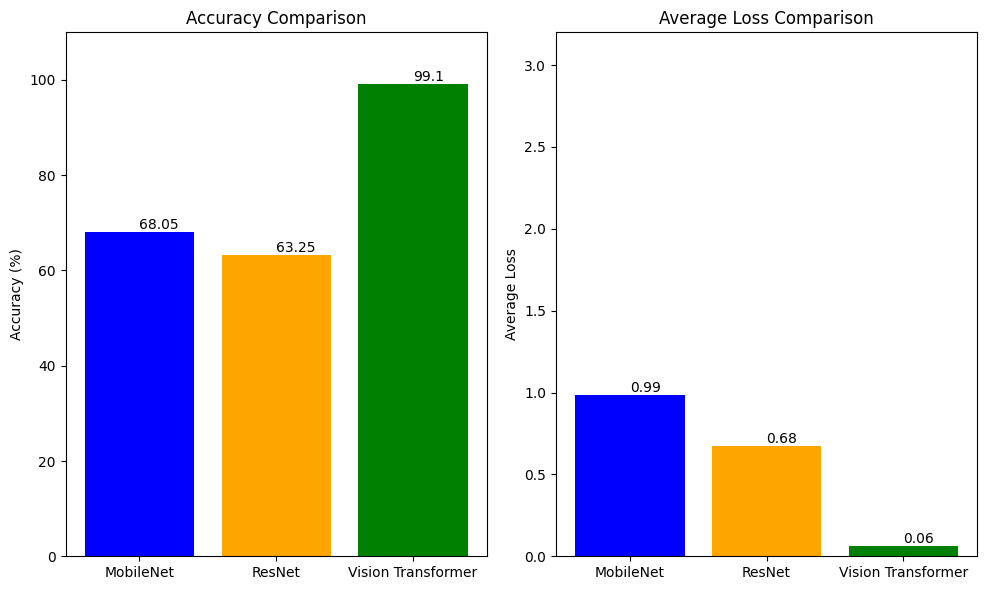

In [35]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(['MobileNet', 'ResNet', 'Vision Transformer'], [mobilenet_accuracy, Resnet_accuracy, vit_accuracy], color=['blue', 'orange', 'green'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 110)

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

# Loss comparison
plt.subplot(1, 2, 2)
bars = plt.bar(['MobileNet', 'ResNet', 'Vision Transformer'], [modilenet_avg_loss, Resnet_avg_loss, vit_avg_loss], color=['blue', 'orange', 'green'])
plt.title('Average Loss Comparison')
plt.ylabel('Average Loss')
plt.ylim(0, 3.2)

# Annotate bars with values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

plt.tight_layout()
plt.show()
